# Transfer Learning using ResNet

Keras provides access to a number of top-performing pre-trained models that were developed for image recognition tasks.

It include functions to load a model with or without the pre-trained weights, and prepare data in a way that a given model may expect (e.g. scaling of size and pixel values).

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model

from keras.applications.resnet_v2 import ResNet50V2, preprocess_input, decode_predictions

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

### Load a pre-trained ResNet50V2 model

When loading a given model, the **“include_top”** argument can be set to **False**, in which case the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained.

The first time a pre-trained model is loaded, Keras will download the required model weights, which may take some time given the speed of your internet connection. Weights are stored in the .keras/models/ directory under your home directory and will be loaded from this location the next time that they are used.

It will output something like Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [3]:
# re-size all the images to this
# Change this depending on dataset
IMAGE_SIZE = [100, 100] 

In [4]:
# load model without output layer and discards the last 1000 neuron layer.
base_model = ResNet50V2(include_top=False, weights='imagenet')

base_model.summary()
# You should not see the fully connected Dense layer in the summary below because of include_top=False
# Compare this with the output when include_top=True

94668760/94668760 [==============================] - 2s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                        

## Remainder of the code would look similar to what we used for VGG-16

In [5]:
# training config:
# Start with a smaller number for epochs and then go up as it would take longer
epochs = 3
batch_size = 32

###  Fruit 360 Dataset from Kaggle - A dataset of images containing fruits and vegetables

In [6]:
# Dataset from Kaggle: https://www.kaggle.com/moltean/fruits
train_path = r'C:\CIS360\week3\module3_codesamples\Fruit360_small\Fruit360_small\Training'
valid_path = r'C:\CIS360\week3\module3_codesamples\Fruit360_small\Fruit360_small\Test'

In [7]:
from glob import glob
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [8]:
# useful for getting number of classes
folders = glob(train_path + '/*')

### Length of the folders is how many different classes of Fruits we have here

In [9]:
print(len(folders))

7


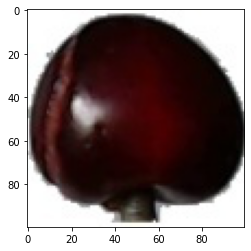

In [10]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

## Freeze the VGG layers

Lets mark the original VGG layers as non-trainable. Since we only want to add our own fully connected Dense layer for classifying fruits

In [11]:
# don't train existing weights
for layer in base_model.layers:
  layer.trainable = False

### Add our custom layers to classify fruits. Change below code depending on your dataset and problem.

In [12]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)

In [13]:
x=base_model.output
x=GlobalMaxPooling2D()(x)
x.shape

TensorShape([None, 2048])

In [14]:
# WE WILL ADD A DENSE LAYER JUST FOR FUN
x = Dense(1000, activation='relu')(x)

# Add a Dense layer to classify Fruits. 
#Number of target class = number of folders in our fruit-360 dataset
prediction = Dense(len(folders), activation='softmax')(x)

In [15]:
# create a model object
transfer_model = Model(inputs=base_model.input, outputs=prediction)

## Let's view the structure of the model

In [16]:
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
# tell the model what cost and optimization method to use
transfer_model.compile(
  loss='categorical_crossentropy',
  optimizer='Adam',
  metrics=['accuracy']
)

In [18]:
# create an instance of ImageDataGenerator. Using VGG16 preprocess_input
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [19]:
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 1181 images belonging to 7 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Blueberry': 3, 'Cauliflower': 4, 'Cherry 1': 5, 'Eggplant': 6}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -0.9922943 max: 1.0


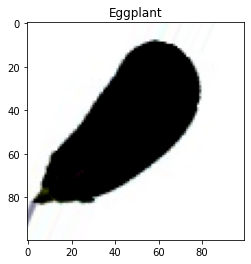

In [21]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

### Create generators for training and validation images

In [22]:
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3533 images belonging to 7 classes.


In [23]:
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 1181 images belonging to 7 classes.


## fit the model

In [25]:
r = transfer_model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/3
110/110 [==============================] - 204s 2s/step - loss: 0.5750 - accuracy: 0.9717 - val_loss: 1.3948 - val_accuracy: 0.9332
Epoch 2/3
110/110 [==============================] - 193s 2s/step - loss: 0.0650 - accuracy: 0.9951 - val_loss: 0.1596 - val_accuracy: 0.9835
Epoch 3/3
110/110 [==============================] - 184s 2s/step - loss: 0.0614 - accuracy: 0.9954 - val_loss: 0.0589 - val_accuracy: 0.9922


In [26]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = transfer_model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


In [27]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 3533
Found 3533 images belonging to 7 classes.
50
[[492   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0]
 [  0   0 490   0   0   0   0]
 [  0   0   0 462   0   0   0]
 [  2   0   0   0 700   0   0]
 [  0   0   0   0   0 487   5]
 [  0   0   0   0   0   0 468]]
Generating confusion matrix 1181
Found 1181 images belonging to 7 classes.
[[164   0   0   0   0   0   0]
 [  1 142   0   0   0   0   0]
 [  0   0 166   0   0   0   0]
 [  0   0   0 154   0   0   0]
 [  2   0   0   0 232   0   0]
 [  0   0   0   0   0 162   2]
 [  0   0   0   0   0   0 156]]


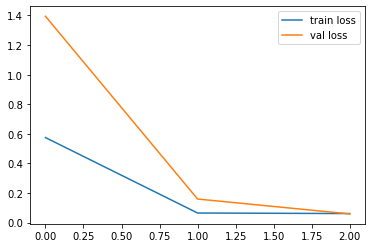

In [28]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

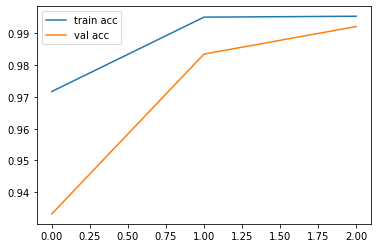

In [29]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()